In [4]:
using Chemfiles
using Plots
using DataFrames, FileIO

home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [5]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [6]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_middle, out_counts
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [16]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = eval(:(ndd_out_4xcp .- vol_avg_4xcp))
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

### Obtiene los aa's del hueco

In [18]:
# VGV cartesiano
xyz_vgv_4xcp = tognm(modes_4xcp * vgv_4xcp)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_4xcp = get_pnum(xyz_vgv_4xcp)

# Índices de pnumber aminoácidos
idx_cut_4xcp = sort(sortperm(abs.(xyz_vgv_4xcp), rev = true)[1:cut_4xcp])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_4xcp_3 = Array{Int64}(length(idx_cut_4xcp) * 3)
for i = 1:length(idx_cut_4xcp)
    idx_cut_4xcp_3[3*i-2] = idx_cut_4xcp[i] * 3 - 2
    idx_cut_4xcp_3[3*i-1] = idx_cut_4xcp[i] * 3 - 1
    idx_cut_4xcp_3[3*i] = idx_cut_4xcp[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [19]:
# Pnumber de VGV
vgv_pnu_4xcp = get_pnum(vgv_4xcp)

# Pnumber indices
idx_vgv_pnu_4xcp = sortperm(abs.(vgv_4xcp), rev=true)[1:vgv_pnu_4xcp]

# Pnumber modes
modes_pnu_4xcp = modes_4xcp[:, idx_vgv_pnu_4xcp]

# Pnumber eigenvalues
evals_pnu_4xcp = evals_4xcp[idx_vgv_pnu_4xcp];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_4xcp = modes_4xcp[idx_cut_4xcp_3, :]
modes_cut_4xcp = mapslices(x -> x ./ norm(x), modes_cut_4xcp, 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_4xcp = modes_pnu_4xcp[idx_cut_4xcp_3, :]
modes_pnu_cut_4xcp = mapslices(x -> x ./ norm(x), modes_pnu_cut_4xcp, 1);

### κ

In [20]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_4xcp, 1), 1)))
κ_modes_4xcp = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_4xcp, 1), 1)))
κ_modes_pnu_4xcp  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_4xcp, 1), 1)
κ_modes_cut_4xcp  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_cut_4xcp, 1), 1)
κ_modes_pnu_cut_4xcp = reshape(tmp, length(tmp));

### Pnumber

In [21]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_4xcp, 1), 1)
col_modes_4xcp = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_4xcp, 1), 1)
col_modes_pnu_4xcp = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_4xcp, 1), 1)
col_modes_cut_4xcp = reshape(tmp, length(tmp))  ./ cut_4xcp

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_cut_4xcp, 1), 1)
col_modes_pnu_cut_4xcp = reshape(tmp, length(tmp))  ./ cut_4xcp;

## Frecuencia

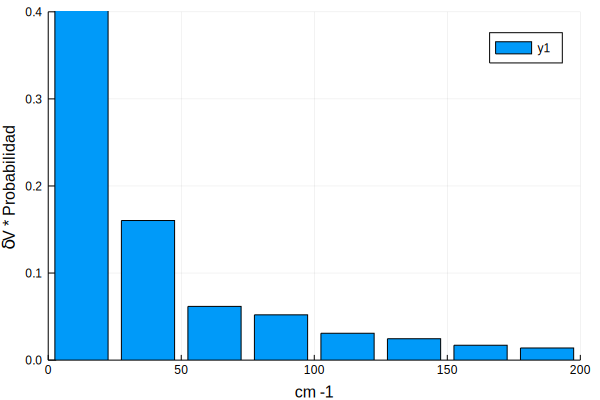

In [22]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_4xcp)
bins_evals = collect(0:25:400)

# Histograma ponderado
Wbins_evals_4xcp, Whis_evals_4xcp = WeightedHist(evals_4xcp, bins_evals, abs.(vgv_4xcp), true);

bar(Wbins_evals_4xcp, Whis_evals_4xcp,
    xlims = (0, 200), ylims = (0, .4),
    yaxis = "\\deltaV * Probabilidad", xaxis = "cm -1")

## Colectividad

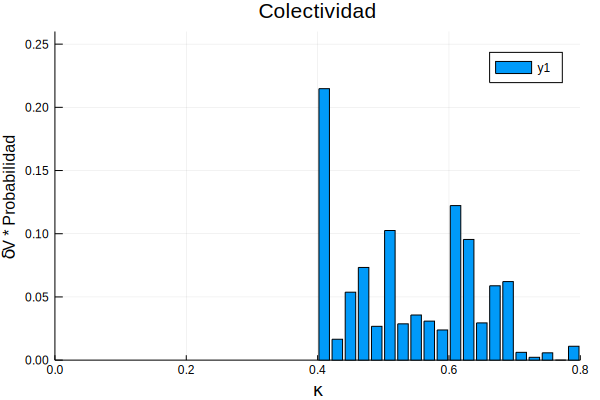

In [24]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_4xcp)
bins_κ = collect(0.4:.02:.8)

# Histograma ponderado
Wbins_κ_4xcp, Whis_κ_4xcp = WeightedHist(κ_modes_4xcp, bins_κ, abs.(vgv_4xcp), true);

bar(Wbins_κ_4xcp, Whis_κ_4xcp,
    title = "Colectividad",
    xlims = (0, .8), ylims = (0, .26),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

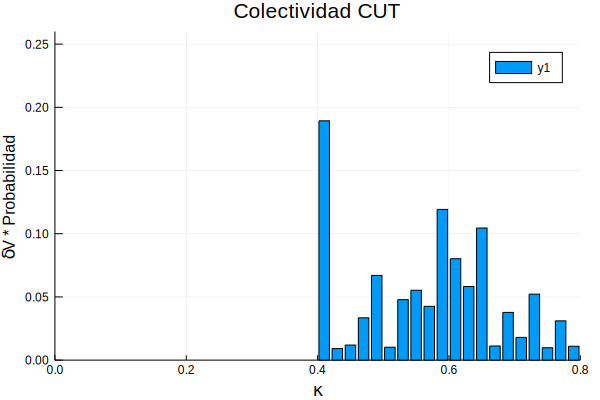

In [25]:
Wbins_κ_cut_4xcp, Whis_κ_cut_4xcp = WeightedHist(κ_modes_cut_4xcp, bins_κ, abs.(vgv_4xcp), true);

bar(Wbins_κ_cut_4xcp, Whis_κ_cut_4xcp,
    title = "Colectividad CUT",
    xlims = (0, .8), ylims = (0, .26),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

## Colectividad en pnumber

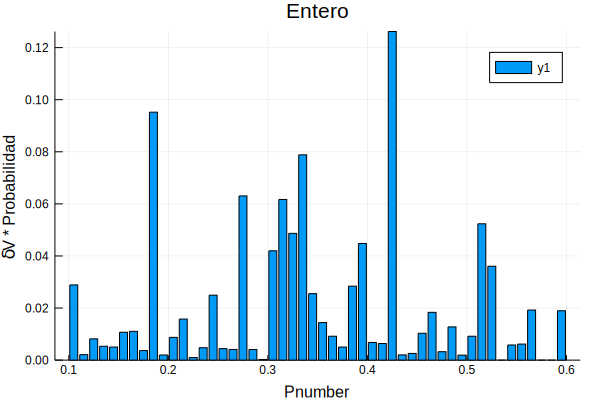

In [39]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_4xcp)
bins_col = collect(0.1:.01:.6)

# Histograma ponderado
Wbins_col_4xcp, Whis_col_4xcp = WeightedHist(col_modes_4xcp, bins_col, abs.(vgv_4xcp), true);

bar(Wbins_col_4xcp, Whis_col_4xcp,
    #xlims = (0.1, .6), ylims = (0, .3),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Entero")

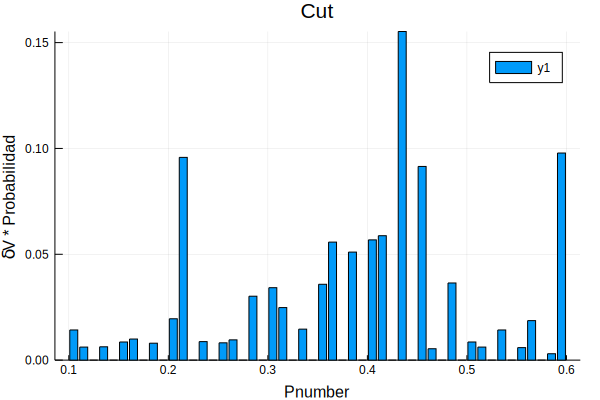

In [38]:
# Uso los bins de arriba
# Histograma ponderado
Wbins_col_cut_4xcp, Whis_col_cut_4xcp = WeightedHist(col_modes_cut_4xcp, bins_col, abs.(vgv_4xcp), true);

bar(Wbins_col_cut_4xcp, Whis_col_cut_4xcp,
    #xlims = (0.1, .6), ylims = (0, .3),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Cut")

## AAs de la pared

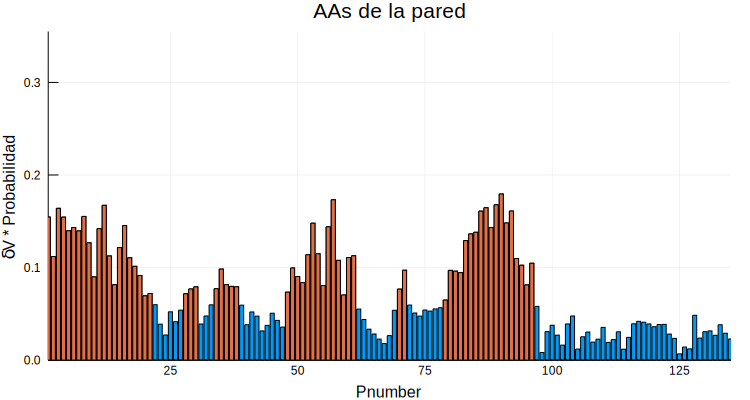

In [40]:
tmp = abs.(xyz_vgv_4xcp)
tmp_ = copy(tmp)
tmp_[tmp_ .< .06] .= 0.;

bar(tmp,
    xlims = (1, 135), ylims = (0, .355),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "AAs de la pared",
    legend = false, size = (750, 400))
bar!(tmp_)

## Volumen de la trayectoria

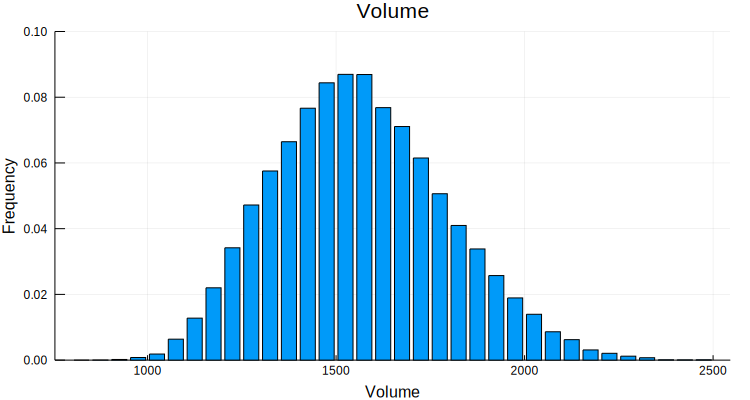

In [39]:
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

bin_vol = collect(800:50:2500)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_4xcp, Whis_vol_4xcp = WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_4xcp, Whis_vol_4xcp,
    ylims = (0, .1),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = false, size = (750, 400))

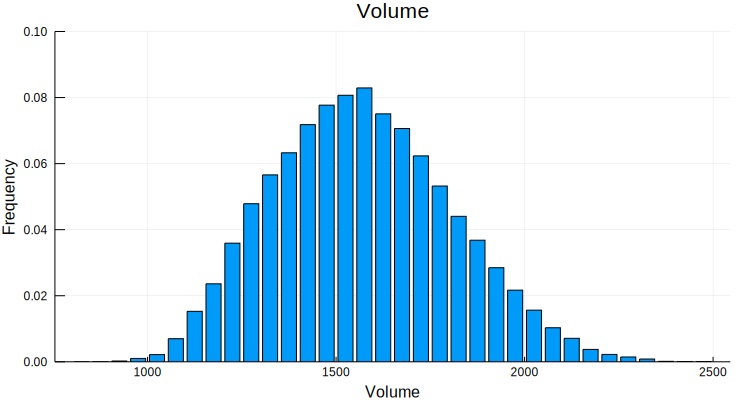

In [41]:
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

bin_vol = collect(800:50:2500)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_4xcp, Whis_vol_4xcp = WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_4xcp, Whis_vol_4xcp,
    ylims = (0, .1),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    legend = false, size = (750, 400))

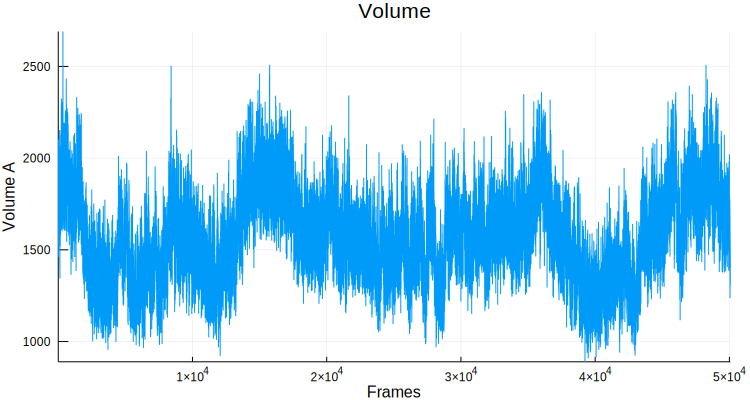

In [43]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    legend = false, size = (750, 400))

In [44]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 1570.33 
  236.702

# Energía

In [45]:
points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_4xcp = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_4xcp[i] = energia_gdte(evals_4xcp, vgv_4xcp, d * 5E-1)
end

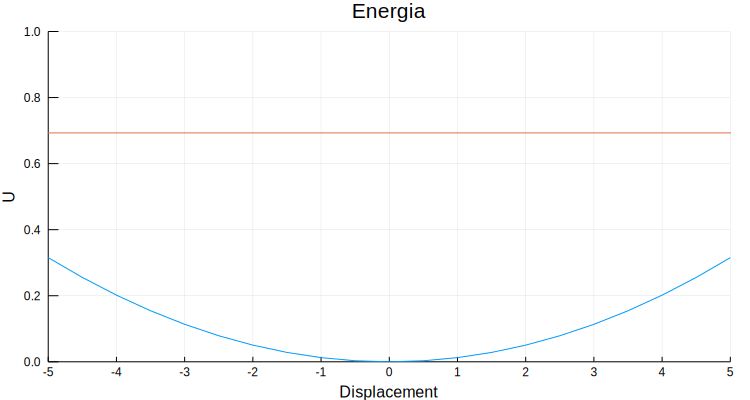

In [46]:
plot(collect(-5:.5:5), E_4xcp,
    yaxis = "U", xaxis = "Displacement", title = "Energia",
    xticks = -5:1:5,
    ylims = (0, 1.),
    legend = false, size = (750, 400))
hline!([RT])

# Energía de poblaciones

In [51]:
# Leo modos
modes_0, evals_0 = read_ptraj_modes(joinpath(home, pdb, "poblaciones", "pca", string("full_modes_", pdb, "_0")))
modes_1, evals_1 = read_ptraj_modes(joinpath(home, pdb, "poblaciones", "pca", string("full_modes_", pdb, "_1")))
modes_2, evals_2 = read_ptraj_modes(joinpath(home, pdb, "poblaciones", "pca", string("full_modes_", pdb, "_2")))

# Leo volúmenes originales
vol_avg_0 = convert(Float64, readdlm(joinpath(home, pdb, "poblaciones", "ndd", "0", string("vol_avg_", pdb, "_0")))[2])
vol_avg_1 = convert(Float64, readdlm(joinpath(home, pdb, "poblaciones", "ndd", "1", string("vol_avg_", pdb, "_1")))[2])
vol_avg_2 = convert(Float64, readdlm(joinpath(home, pdb, "poblaciones", "ndd", "2", string("vol_avg_", pdb, "_2")))[2])

# Leo volúmenes NDD
ndd_out_0 = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "poblaciones", "ndd", "0", string("out_ndd_", pdb, "_0")))[2:end, 2])
# VGV
vgv_0 = ndd_out_0 .- vol_avg_0
vgv_0 = vgv_0 ./ norm(vgv_0);

# Leo volúmenes NDD
ndd_out_1 = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "poblaciones", "ndd", "1", string("out_ndd_", pdb, "_1")))[2:end, 2])
# VGV
vgv_1 = ndd_out_1 .- vol_avg_1
vgv_1 = vgv_1 ./ norm(vgv_1);

# Leo volúmenes NDD
ndd_out_2 = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "poblaciones", "ndd", "2", string("out_ndd_", pdb, "_2")))[2:end, 2])
# VGV
vgv_2 = ndd_out_2 .- vol_avg_2
vgv_2 = vgv_2 ./ norm(vgv_2);

In [52]:
points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_0 = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_0[i] = energia_gdte(evals_0, vgv_0, d * 5E-1)
end

points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_1 = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_1[i] = energia_gdte(evals_1, vgv_1, d * 5E-1)
end

points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_2 = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_2[i] = energia_gdte(evals_2, vgv_2, d * 5E-1)
end

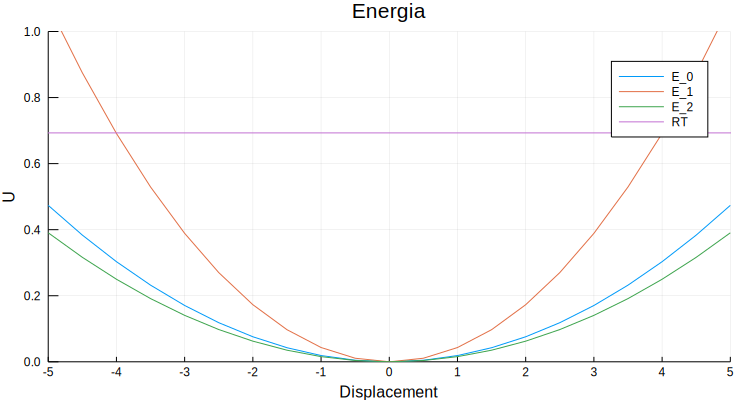

In [67]:
plt_u = plot(collect(-5:.5:5), E_0,
    yaxis = "U", xaxis = "Displacement", title = "Energia",
    xticks = -5:1:5,
    ylims = (0, 1.),
    lab = "E_0", size = (750, 400))
plot!(plt_u, collect(-5:.5:5), E_1, lab = "E_1")
plot!(plt_u, collect(-5:.5:5), E_2, lab = "E_2")
hline!(plt_u, [RT], lab = "RT")

# PCA projección

#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

In [47]:
#
# Get avg ready
#
function salvo_memoria(in_avg_filename, in_trj_filename, mask)

    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] = reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        gc()
    end

    return diff_pdb
end

salvo_memoria (generic function with 1 method)

In [48]:
diff = salvo_memoria(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")),
    joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    collect(10:144))
writedlm(joinpath(rtdos, string("diff_", pdb)), diff)

1
2
3
4
5
6
7
8
9
10


405×500000 Array{Float64,2}:
  1.09743     0.958855     0.560104    0.379963  …   0.576687    -0.229046  
  0.0220356   0.449156     0.133007    0.231842     -0.946802    -0.562859  
 -1.02032    -1.03153     -1.27069    -1.11587      -0.84177     -1.11797   
  1.20828     0.931599     0.5233      0.548672      0.438564    -0.157215  
  0.0325966   0.0833511   -0.243177    0.160341     -0.708031    -0.705585  
 -1.3327     -1.04097     -1.28983    -1.62862   …  -0.59964     -1.02882   
  1.3027      1.11352      1.0445      0.763863      0.432831    -0.356575  
 -0.640856   -0.604769    -0.777042   -0.675875     -0.791416    -0.672136  
 -1.8506     -1.64106     -1.55009    -2.36226      -0.60553     -1.02965   
  1.07299     1.18108      0.959438    0.504089      0.568066     0.339039  
 -1.00172    -0.965982    -0.862684   -1.31577   …  -0.69306     -1.01627   
 -1.28878    -1.08772     -1.19102    -1.5147       -0.642082    -1.0189    
  0.713684    0.961063     0.610134    0.4049  

### Obtengo proyecciones de PCA sobre trayectoria

In [50]:
diff = readdlm(joinpath(rtdos, string("diff_", pdb)))
nframes = size(diff)[2]
norm_diff = mapslices(x -> x ./ norm(x), diff, 1);

prj_1_4xcp = Array{Float64, 1}(nframes)
prj_2_4xcp = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_diff[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_diff[:, i], modes_4xcp[:, 2])
end

df_prj_4xcp = DataFrame(PCA1 = prj_1_4xcp, PCA2 = prj_2_4xcp,
    Time = collect(1:length(prj_1_4xcp)));

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+10]) for i = 1:10:length(prj_1_4xcp)-10 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+10]) for i = 1:10:length(prj_2_4xcp)-10 ];

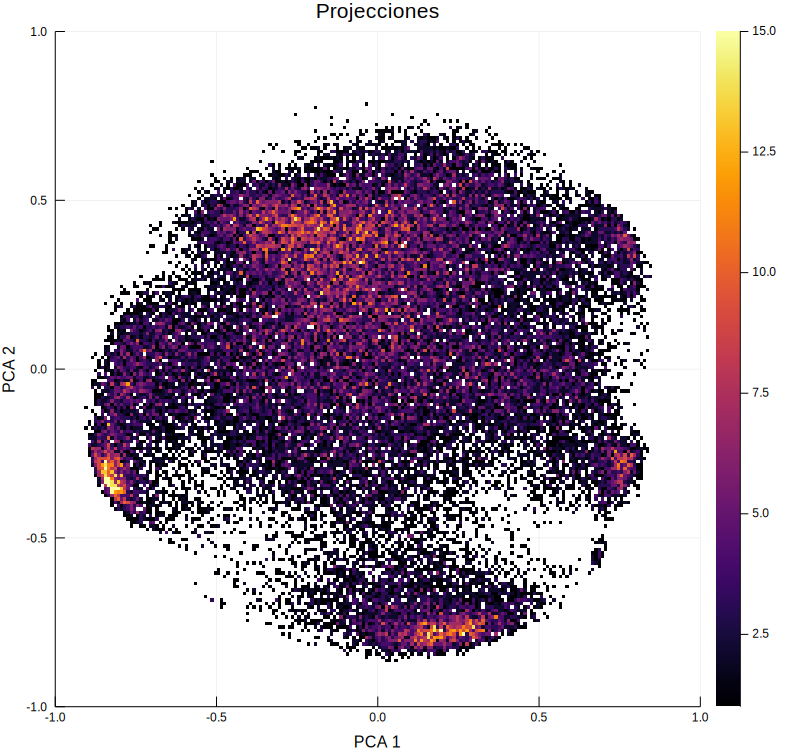

In [52]:
plt_2his = histogram2d(smooth_prj_1_4xcp, smooth_prj_2_4xcp, 
    xlims = (-1., 1.), ylims = (-1., 1.),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "Projecciones",
    clims = (1, 15), colorbar_title = "Frame count",
    nbins = 200, size = (800, 750))

#### Leo los vectores diferencia y los normalizo
#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

## Separo las poblaciones según PCA

In [55]:
# Hago esto 1 sola vez
in_bins = collect(-1:.025:1)
his_ind, his = MatHisInd2D(prj_1_4xcp, prj_2_4xcp, in_bins, in_bins);

msk = his .> 150
main_his = his[msk]
main_his_ind = his_ind[msk];

In [106]:
# Hago esto 1 sola vez
in_bins = collect(-1:.025:1)
his_ind, his = MatHisInd2D(prj_1_4xcp, prj_2_4xcp, in_bins, in_bins);

msk = his .> 125
main_his = his[msk]
main_his_ind = his_ind[msk];

# 0
spy(msk[40:60, 6:16])
# 1
spy(msk[68:74, 26:33])
# 2
spy(msk[69:75, 52:62])
# 3
spy(msk[22:60, 37:72])
# 4
spy(msk[4:17, 19:50])

idx_vol0 = collect(Iterators.flatten(his_ind[40:60, 6:16]))

idx_vol1 = collect(Iterators.flatten(his_ind[68:74, 26:33]))
idx_vol2 = collect(Iterators.flatten(his_ind[69:75, 52:62]))
idx_vol3 = collect(Iterators.flatten(his_ind[22:60, 37:72]))
idx_vol4 = collect(Iterators.flatten(his_ind[4:17, 19:50]))

# Indices de poblaciones
writedlm(joinpath(rtdos, string(pdb,"_re_idx_vol0")), idx_vol0)

writedlm(joinpath(rtdos, string(pdb,"_re_idx_vol1")), idx_vol1)
writedlm(joinpath(rtdos, string(pdb,"_re_idx_vol2")), idx_vol2)
writedlm(joinpath(rtdos, string(pdb,"_re_idx_vol3")), idx_vol3)
writedlm(joinpath(rtdos, string(pdb,"_re_idx_vol4")), idx_vol4)

In [107]:
idx_vol0 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_re_idx_vol0")))[:, 1])
idx_vol1 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_re_idx_vol1")))[:, 1])
idx_vol2 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_re_idx_vol2")))[:, 1])
idx_vol3 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_re_idx_vol3")))[:, 1])
idx_vol4 = convert(Array{Int64}, readdlm(joinpath(rtdos, string(pdb, "_re_idx_vol4")))[:, 1])

# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_vol0]
trj_vol1 = full_trj_vol[idx_vol1]
trj_vol2 = full_trj_vol[idx_vol2]
trj_vol3 = full_trj_vol[idx_vol3]
trj_vol4 = full_trj_vol[idx_vol4];

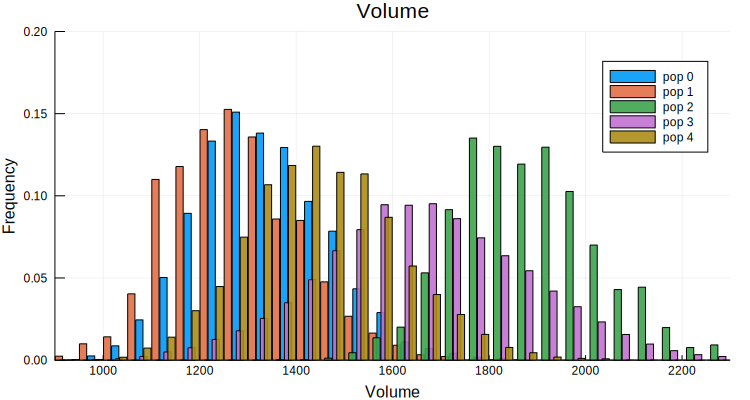

In [138]:
###### st = 50
bin_vol = collect(800:st:2400)

# Histograma ponderado
wgh_vol = fill(1.0, length(idx_vol0))
bin_vol0_4xcp, his_vol0_4xcp = WeightedHist(trj_vol0, bin_vol, wgh_vol, true, false);

wgh_vol = fill(1.0, length(idx_vol1))
bin_vol1_4xcp, his_vol1_4xcp = WeightedHist(trj_vol1, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(idx_vol2))
bin_vol2_4xcp, his_vol2_4xcp = WeightedHist(trj_vol2, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(idx_vol3))
bin_vol3_4xcp, his_vol3_4xcp = WeightedHist(trj_vol3, bin_vol, wgh_vol, true, false)

wgh_vol = fill(1.0, length(idx_vol4))
bin_vol4_4xcp, his_vol4_4xcp = WeightedHist(trj_vol4, bin_vol, wgh_vol, true, false)

plt_his_vols = bar([ bin_vol0_4xcp ; bin_vol1_4xcp .- st/3 ; bin_vol2_4xcp .- st/6 ;
        bin_vol3_4xcp .+ st/6 ; bin_vol4_4xcp .+ st/3 ],
    [ his_vol0_4xcp ; his_vol1_4xcp ; his_vol2_4xcp ; his_vol3_4xcp ; his_vol4_4xcp ],
    group = repeat(["pop 0" ; "pop 1" ; "pop 2" ; "pop 3" ; "pop 4"], inner = length(bin_vol1_4xcp)),
    bar_position = :stacked, fillalpha = .9, bar_width = 15, size = (1800, 900),
    xlims = (900, 2300), ylims = (0, .20),
    yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    size = (750, 400))

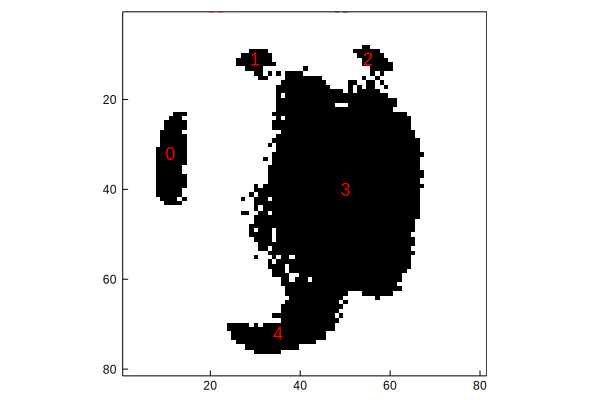

In [151]:
spy(msk)
annotate!(11, 32, text("0", 12, :red))
annotate!(30, 11, text("1", 12, :red))
annotate!(55, 11, text("2", 12, :red))
annotate!(50, 40, text("3", 12, :red))
annotate!(35, 72, text("4", 12, :red))

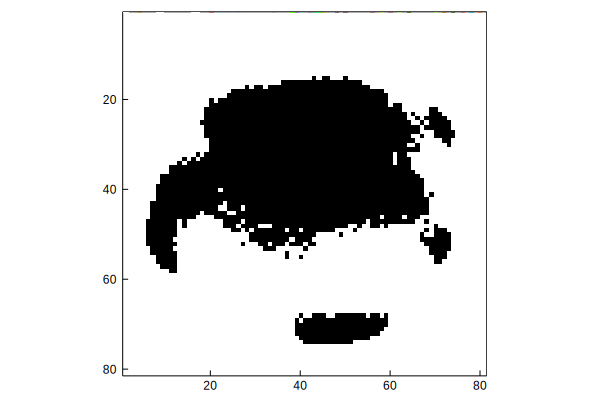

In [116]:
spy(transpose(msk))

In [113]:
df_datos = DataFrame(MEAN = [ mean(trj_vol0) ; mean(trj_vol1) ;
        mean(trj_vol2) ; mean(trj_vol3) ; mean(trj_vol4) ],
    STD = [ std(trj_vol0) ; std(trj_vol1) ; std(trj_vol2) ; std(trj_vol3) ; std(trj_vol4) ],
    CFMR = [ 0 ; 1 ; 2 ; 3 ; 4 ])

,MEAN,STD,CFMR
1,1323.7175597454493,134.34008866008057,0
2,1279.360231716621,132.88901016288202,1
3,1882.7755868791996,149.67736341850673,2
4,1660.9993714197267,214.9512263521604,3
5,1445.2165568042417,156.94312685540223,4


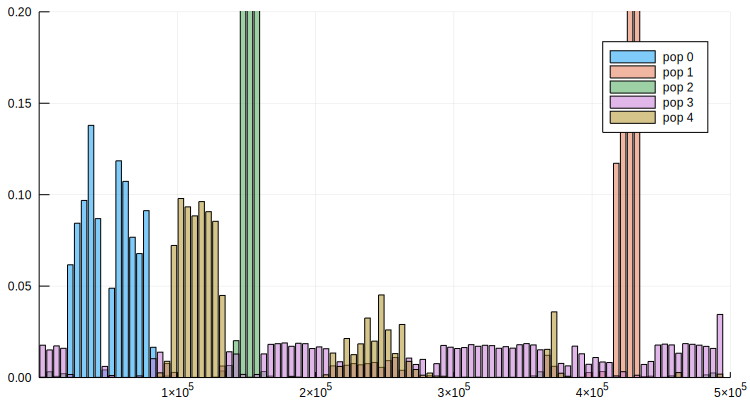

In [118]:
bin_rms = collect(1:5000:500000)

# Histograma ponderado
bin_0, his_0 = WeightedHist(idx_vol0, bin_rms, fill(1., length(idx_vol0)), true)
bin_1, his_1 = WeightedHist(idx_vol1, bin_rms, fill(1., length(idx_vol1)), true)
bin_2, his_2 = WeightedHist(idx_vol2, bin_rms, fill(1., length(idx_vol2)), true)
bin_3, his_3 = WeightedHist(idx_vol3, bin_rms, fill(1., length(idx_vol3)), true)
bin_4, his_4 = WeightedHist(idx_vol4, bin_rms, fill(1., length(idx_vol4)), true)

bar([ bin_0 ; bin_1 .- st/3 ; bin_2 .- st/6 ; bin_3 .+ st/6 ; bin_4 .+ st/3 ],
    [ his_0 ; his_1 ; his_2 ; his_3 ; his_4 ],
    group = repeat(["pop 0" ; "pop 1" ; "pop 2" ; "pop 3" ; "pop 4"], inner = length(bin_1)),
    fillalpha = .5, 
    xlims = (1, 5E5), ylims = (0, .2),
    #yaxis = "Frequency", xaxis = "Volume", title = "Volume",
    size = (750, 400))

In [121]:
grupos = [ fill("pop 3", length(idx_vol3)) ; fill("pop 0", length(idx_vol0)) ; 
    fill("pop 1", length(idx_vol1)) ; 
    fill("pop 2", length(idx_vol2)) ; fill("pop 4", length(idx_vol4)) ]

plt_vol_pop = scatter( [ idx_vol3 ; idx_vol0 ; idx_vol1 ; idx_vol2 ; idx_vol4 ],
    [ trj_vol3 ; trj_vol0 ; trj_vol1 ; trj_vol2 ; trj_vol4 ],
    groups = grupos, 
    markersize = 1., markeralpha = .4, markerstrokewidth = .1,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    #ylims = (100, 2000),
    size = (750, 400));

In [69]:
############## CSV ##############
# Projecciones de PCA
df_prj = DataFrame(PCA1 = smooth_prj_1_4xcp, PCA2 = smooth_prj_2_4xcp);
save(joinpath(rtdos, string("2his_prj_", pdb, ".csv")), df_prj, quotechar = nothing)

# Volumen
df_vol = DataFrame(Volumen = trj_vol);
save(joinpath(rtdos, string("vol_", pdb, ".csv")), df_vol, quotechar = nothing)
# Volumenes
save(joinpath(rtdos, string("vol1_", pdb, ".csv")), 
    DataFrame(vol1 = trj_vol1), quotechar = nothing)
save(joinpath(rtdos, string("vol2_", pdb, ".csv")), 
    DataFrame(vol2 = trj_vol2), quotechar = nothing)
save(joinpath(rtdos, string("vol3_", pdb, ".csv")), 
    DataFrame(vol3 = trj_vol3), quotechar = nothing)
save(joinpath(rtdos, string("vol4_", pdb, ".csv")), 
    DataFrame(vol4 = trj_vol4), quotechar = nothing)

############## PNG ##############
png(plt_his_vol, joinpath(rtdos, "papel", string("plt_his_vol_", pdb)))
png(plt_2his, joinpath(rtdos, "papel", string("plt_2his_", pdb, ".png")))
png(plt_his_vols, joinpath(rtdos, "papel", string("plt_his_vols_", pdb)))
png(plt_vol_pop, joinpath(rtdos, "papel", string("plt_vol_pop_", pdb)))

In [122]:
png(plt_vol_pop, joinpath(rtdos, "papel", string("plt_re_vol_pop_", pdb)))